In [1]:
# Common imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.figsize'] = (10, 5)

In [2]:
import os
import urllib
import shutil

def download_file(url, dir_path="data"):
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        
    file_name = os.path.split(url)[-1]
    file_path = os.path.join(dir_path, file_name)
    
    with urllib.request.urlopen(url) as response, open(file_path, 'wb') as out_file:
        shutil.copyfileobj(response, out_file)
        
    return file_path

In [3]:
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler

## Трансформация данных (feature selection & feature extraction)

Для повышения качества работы ML моделей можно использовать только часть доступных атрибутов. Процедура выбора наиболее значимых атрибутов называется feature selection. 

Атрибуты можно комбинировать друг с другом. Предположим, что количество выпускаемых на заводе деталей зависит от количества сотрудников и количества конвейеров. В идеале, чем больше сотрудников и конвейеров, тем больше деталей производится. Если мы добавим конвейер, но не добавим на него людей, то никакой пользы от добавления конвейера не будет. Следовательно, в модель нужно добавить атрибут, учитывающий связь между сотрудниками и конвейерами. Поиск комбинаций атрибутов на основе знаний о природе исходных данных называется feature engineering.

# Рекламный бюджет

In [4]:
download_file("http://www-bcf.usc.edu/~gareth/ISL/Advertising.csv")
adv_df = pd.read_csv('data/Advertising.csv', usecols=[1,2,3,4])
adv_df.head()

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [5]:
adv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
TV           200 non-null float64
radio        200 non-null float64
newspaper    200 non-null float64
sales        200 non-null float64
dtypes: float64(4)
memory usage: 6.3 KB


Выше представлены данные о продажах некоторого продукта (sales, в тысячах штук) в зависимости от рекламного бюджета (в тысячах долларов), потраченного на различные медиа (TV, Radio и Newspapers). Предположим, что вы консультант, которого попросили создать маркетинговый план на следующий год на основе этих данных, так, чтобы продажи продукта были высокими.

 ## Что мы пытаемся понять?

1. Есть ли связь между рекламным бюджетом и продажами?
2. Насколько сильна связь между бюджетом и продажами? Можем ли мы предсказывать продажи на основе бюджета?
3. Какие медиа способствуют продажам?
4. Насколько точно мы можем предсказывать будущие продажи?
6. Линейная ли зависимость между бюджетом и продажами?
7. Есть ли эффект взаимодействия (synergy/interaction effect) между медийными бюджетами?

Мы ответим на эти вопросы, используя только линейную регрессию.

## Выбор модели

In [6]:
from sklearn.linear_model import LinearRegression

<Figure size 1080x576 with 0 Axes>

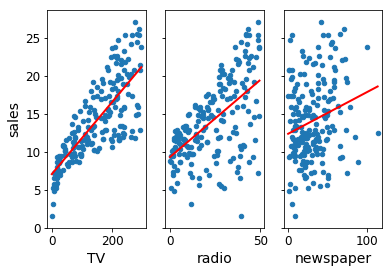

In [7]:
fig = plt.figure(figsize=(15,8))
fig.suptitle('Зависимость от компонент', fontsize=20)
fig, axes = plt.subplots(1, 3, sharey=True)
y_col = 'sales'
for i, x_col in enumerate(adv_df.columns.drop(y_col)):
    adv_df.plot.scatter(x_col, y_col, ax=axes[i])
    
    lm = LinearRegression().fit(
        adv_df[x_col].values.reshape(-1, 1), 
        adv_df[y_col].values.reshape(-1, 1)
    )
    xs = np.array([adv_df[x_col].min(), adv_df[x_col].max()]).reshape(-1, 1)
    ys = lm.predict(xs)
    axes[i].plot(xs, ys, c='r', linewidth=2)

У нас есть 3 атрибута и мы считаем, что все они полезные. Так как мы используем линейную регрессию, модель будет выглядеть следующим образом:
$$sales = \beta_0 + \beta_1 * TV + \beta_2 * Radio + \beta_3 * Newspaper$$

На данный момент мы опустим тот факт, что медийные бюджеты в нашей модели не влияют друг на друга.

## t-statistcs,  p-value, $R^2$, RSE, F-statistics

Итак, у нас есть линейная модель и мы можем посчитать коэффициенты $\beta_0, \beta_1, \beta_2, \beta_3$. Найдем их (и немного статической информации о работе модели), воспользовавшись библиотечкой statsmodel.

In [11]:
est = smf.ols('sales ~ TV + radio + newspaper', adv_df).fit()
est_res = est.summary()
est_res.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.9389,0.312,9.422,0.000,2.324,3.554
TV,0.0458,0.001,32.809,0.000,0.043,0.049
radio,0.1885,0.009,21.893,0.000,0.172,0.206
newspaper,-0.0010,0.006,-0.177,0.860,-0.013,0.011


In [14]:
est = smf.ols('sales ~ TV + radio + newspaper', adv_df).fit()
est_res = est.summary()
est_res.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.9389,0.312,9.422,0.000,2.324,3.554
TV,0.0458,0.001,32.809,0.000,0.043,0.049
radio,0.1885,0.009,21.893,0.000,0.172,0.206
newspaper,-0.0010,0.006,-0.177,0.860,-0.013,0.011


### Standard error

Как мы помним, настоящее линейное представление данных выглядит как:
$$y = \beta_0 + \beta_1 * x_1 + \beta_2 * x_2 + \dots + \beta_n * x_n + \epsilon$$

где $\epsilon$ - неприводимая ошибка (irreducible error). Поэтому наша модель это аппроксимация вида:
$$\hat{y} = \beta_0 + \beta_1 * x_1 + \beta_2 * x_2 + \dots + \beta_n * x_n$$

Более того, так как мы работаем лишь с сэмплом данных (а не с полным набором), то коэффициенты $\beta_0, \beta_1, \beta_2, \dots, \beta_n$ на самом деле тоже аппроксимация ($\hat{\beta_0}, \hat{\beta_1}, \hat{\beta_2}, \dots, \hat{\beta_n}$). И, конечно, нам интересно знать, насколько она точна. Для этих целей используется *стандартная ошибка*.

Стандартную ошибку можно посчитать для каждого параметра (мы опустим особенности и ограничения этих вычислений). Зная стандартные ошибки, можно вычислить доверительные интервалы. Например, $95\%$ значений $\beta_0$ будут в интервале $[2.324, 3.554]$ (т.е., без какой-либо рекламы с 95% уверенностью мы сможем продавать от $2324$ до $3554$ единиц товара).

### Проверка гипотезы (t-statistics и p-value)

Используя стандартные ошибки, мы можем проверять гипотезы. Наиболее популярный тип проверки - сопоставление *нулевой* и *альтернативной гипотезы*:

$H_0$: между $x_i$ и $y$ нет зависимости

$H_a$: между $x_i$ и $y$ есть зависимость

В нашем случае, математически это выглядит так:
$$
H_0: \beta_i = 0 \\
H_a: \beta_i \ne 0
$$

Для проверки этой гипотезы производится t-тест:
$$t = \frac{\hat{\beta_i} - 0}{SE(\hat{\beta_i})}$$
SE - standard error.

Если между $x_i$ и $y$ нет зависимости, то мы ожидаем, что $t$ будет соответствовать $t$-распределению с $n-2$ степенями свободы ($n$ - количество экземпляров в сэмпле). Таким образом, чтобы подтвердить $H_0$ при известном распределении, нам достаточно найти вероятность того, что наблюдаемое значение $\ge |t|$ при условии, что $\beta_i = 0$. Данная вероятность называется $p$-value.

Если $p$-value достаточно маленький (обычно меньше $1\%$), то мы можем отклонить нулевую гипотезу. 

In [15]:
est_res.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.9389,0.312,9.422,0.000,2.324,3.554
TV,0.0458,0.001,32.809,0.000,0.043,0.049
radio,0.1885,0.009,21.893,0.000,0.172,0.206
newspaper,-0.0010,0.006,-0.177,0.860,-0.013,0.011


В нашем случае все медиа, кроме Newspapers, имеют маленький $p$-value. Т.е. между Newspaper и Sales нет линейной зависимости и, следовательно, этого атрибута можно избавиться.

Недостатком определения полезности атрибутов с использованием t-statistics является то, что оценка важности каждого атрибута производится независимо от других, что может быть ошибочно.

### $R^2$

Линейная регрессия минимизирует метрику RSS (residual sum of squares), которая равна сумме квадратов наблюдаемых ошибок:
$$RSS = \sum_{i = 1}^n(y_i - \hat{y_i})^2$$

К сожалению, данная величина абсолютная и по ней сложно определить качество модели. Поэтому качество линейной регрессии часто оценивают при помощи двух других метрик: RSE (residual standard error) и $R^2$.
$$RSE = \sqrt{\frac{1}{n-p-1}RSS}$$

$$R^2 = \frac{TSS - RSS}{TSS} = 1 - \frac{RSS}{TSS}, \quad TSS = \sum_{i = 1}^n(y_i - \bar{y})^2$$

$TSS$ - total sum of squares, $p$ - количество переменных.

* RSE - штрафует модели, которым нужно больше предсказателей (predictors) для достижения одинаковых значения RSS.
* $R^2$ - показывает, какой процент вариативности (variance) объяснен моделью.

Т.е. мы минимизируем RSE и максимизируем $R^2$. $R^2 \in [0, 1]$ - относительная величина, чем ближе к 1, тем лучше.

In [16]:
three_x_lm = smf.ols('sales ~ TV + radio + newspaper', adv_df).fit()
rss = np.sum(three_x_lm.resid ** 2)
print("RSS:", rss)
print("RSE:", np.sqrt(rss / (adv_df.shape[0] - 3 - 1)))
print("R^2:", three_x_lm.rsquared)

RSS: 556.825262902
RSE: 1.68551037341
R^2: 0.897210638179


In [17]:
two_x_lm = smf.ols('sales ~ TV + radio', adv_df).fit()
rss = np.sum(two_x_lm.resid ** 2)
print("RSS:", rss)
print("RSE:", np.sqrt(rss / (adv_df.shape[0] - 2 - 1)))
print("R^2:", two_x_lm.rsquared)

RSS: 556.913980068
RSE: 1.68136091251
R^2: 0.897194261083


Чем проще модель, тем лучше она обобщает. Поэтому в нашем примере модель, в которой есть только TV и Radio, лучше модели с TV, Radio и Newspaper (приблизительно одинаковые $R^2$ и меньший $RSE$). 

**Внимание!!!** Все метрики были посчитаны для тренировочных данных.

### F-statistics

Как мы уже говорили, t-тест рассматривает каждый атрибут независимо от других, что не всегда верно. Давайте исправим это! Начнем с постановки гипотезы. Наша глобальная цель - доказать, что продажи зависят от рекламы как минимум в одном из медиа ресурсов, т.е.:

$$
H_0: \beta_1=\beta_2=\beta_3=0 \\
H_a: \text{как минимум одна из $\beta_i \ne 0$}
$$

Проверить эту нулевую гипотезу можно с использованием F-теста:
$$F = \frac{\frac{(TSS - RSS)}{p}}{\frac{RSS}{(n - p - 1)}}$$

Для линейной модели, если $H_0$ выполняется, числитель и знаменатель стремятся к $\sigma^2$ (квадрат стандартного отклонения) и соответственно $F \to 1$. Иначе $F$ много больше 1. 

Как и в случае с $t$-тестом, существует $F$-распределение. Проверка производится по $p$-value для значения F.

In [12]:
print("F:", est.fvalue)
print("p-value:", est.f_pvalue)

F: 570.2707036590942
p-value: 1.575227256092437e-96


$F$-тест говорит о том, что как минимум один параметр из $\beta_1, \beta_2, \beta_3$ не нулевой. 

$F$-тест можно использовать для проверки равенства нулю только части параметров. Допустим, мы хотим проверить, что $q$ из существующих $p$ параметров равны 0 ($q < p$), тогда:
$$F = \frac{\frac{(RSS_0 - RSS)}{q}}{\frac{RSS}{(n - p - 1)}}$$

$RSS_0$ - модель, в которой $q$ параметров равны 0. 

## Способы выбора подмножества фич

Когда $p$ (количество фич) мало, мы можем найти все существующие комбинации этих фич, построить для каждой из этих комбинаций модель, а затем выбрать лучшую. Очевидно, что это а) дорого, б) с ростом количества фич нам надо оценивать все больше и больше моделей. 

Если на некоторое время забыть про существующие статистические методы feature selection и dimensionality reduction, то можно выделить три классических способа автоматического нахождения эффективного подмножества фич:
* forward selection
* backward selection
* mixed selection

### Forward selection

* Создаем нулевую модель, содержащую только $\beta_0$
* Тренируем $p$ простых линейных регрессий, каждая из которых имеет вид $\beta_0 + \beta_1 * x_1$
* Выбираем модель с наименьшим $RSS$
* Тренируем $p - 1$ простых линейных регрессий, каждая из которых имеет вид $\beta_0 + \beta_1 * x_1 + \beta_2 * x_2$
* ...
* и т.д. до выполнения некоторого условия

### Backward selection

* Создаем нулевую модель, использующую все $p$ параметры
* Делаем t-тест
* Выбираем параметр $i$ c наибольшим $p$-value
* Удаляем параметр $i$, перестраиваем модель
* Делаем t-тест
* ...
* и т.д. до выполнения некоторого условия

### Mixed selection

* Создаем нулевую модель, содержащую только $\beta_0$
* forward step
    * Тренируем $k$ простых линейных регрессий
    * Выбираем модель с наименьшим $RSS$
* backward step
    * Делаем t-тест
    * Выбираем параметр $i$ c $p$-value $< \Theta$ 
    * Если параметр $i$ найден, удаляем его
* forward step
* ...
* и т.д. до выполнения некоторого условия

## Нелинейная зависимость

Итак, мы показали, что нам не нужны газеты. Посмотрим, что у нас получилось.

In [18]:
adv_df.drop(['newspaper'], axis=1).describe()

,TV,radio,sales
count,200.000000,200.000000,200.000000
mean,147.042500,23.264000,14.022500
std,85.854236,14.846809,5.217457
min,0.700000,0.000000,1.600000
25%,74.375000,9.975000,10.375000
50%,149.750000,22.900000,12.900000
75%,218.825000,36.525000,17.400000
max,296.400000,49.600000,27.000000


In [22]:
lm = LinearRegression().fit(
    adv_df[['TV', 'radio']].as_matrix(),
    adv_df["sales"]
)

C:\Users\rajah\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [23]:
# Create a coordinate grid
Radio = np.arange(0,50)
TV = np.arange(0,300)

B1, B2 = np.meshgrid(TV, Radio, indexing='xy')
Z = np.zeros((Radio.size, TV.size))

for (i,j),v in np.ndenumerate(Z):
    Z[i,j] =(lm.intercept_ + B1[i,j] * lm.coef_[0] + B2[i,j] * lm.coef_[1])

Text(0.5,0,'sales')

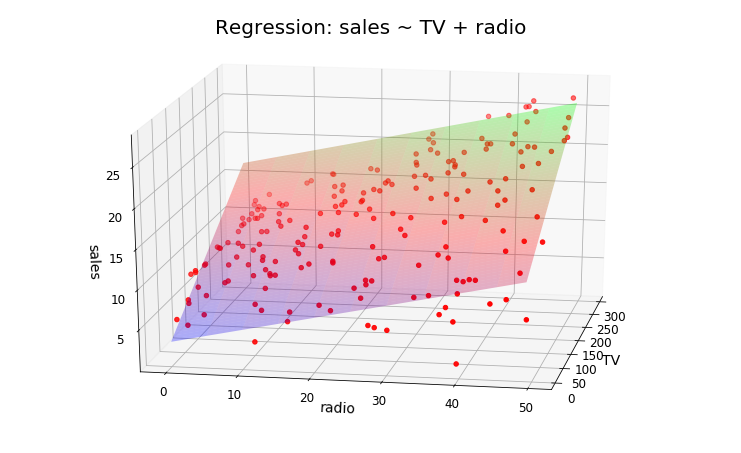

In [24]:
fig = plt.figure(figsize=(10,6))
fig.suptitle('Regression: sales ~ TV + radio', fontsize=20)

ax = axes3d.Axes3D(fig, azim=10, elev=20)
ax.plot_surface(B1, B2, Z, rstride=5, cstride=5, alpha=0.3, cmap=plt.cm.brg)
ax.scatter3D(adv_df.TV, adv_df.radio, adv_df.sales, c='r')
ax.set_xlim(ax.get_xlim()[::-1])

ax.set_xlabel('TV')
ax.set_ylabel('radio')
ax.set_zlabel('sales')

Text(0.5,0,'sales')

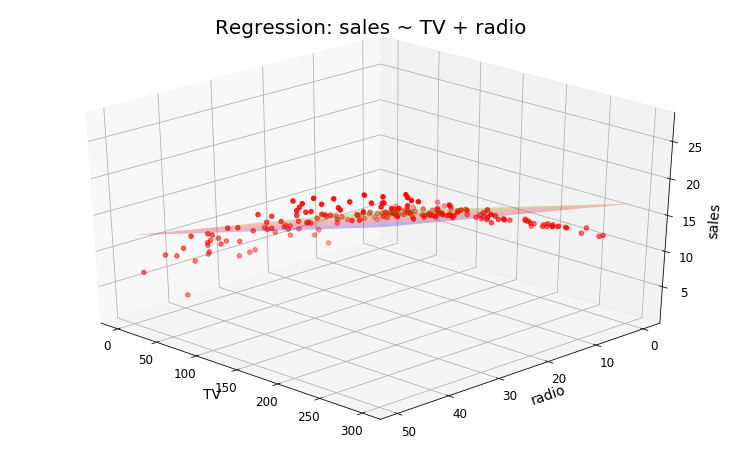

In [25]:
fig = plt.figure(figsize=(10,6))
fig.suptitle('Regression: sales ~ TV + radio', fontsize=20)

ax = axes3d.Axes3D(fig, azim=135, elev=30)
ax.plot_surface(B1, B2, Z, rstride=5, cstride=5, alpha=0.3, cmap=plt.cm.brg)
ax.scatter3D(adv_df.TV, adv_df.radio, adv_df.sales, c='r')
ax.set_xlim(ax.get_xlim()[::-1])

ax.set_xlabel('TV')
ax.set_ylabel('radio')
ax.set_zlabel('sales')

Как видно из изображения, апроксимирующая плоскость переоценивает значения Sales для случаев, когда точки находятся рядом с одной из осей (т.е. зависят только от одного медиа) и недооценивает Sales в случае, когда бюджет разделен между двумя медиа. Следовательно, мы наблюдаем нелинейное поведение (synergy/interaction effect), которое можем использовать в нашей линейной модели.

Наша начальная модель выглядела так:
$$y = \beta_0 + \beta_1 * x_1 + \beta_2 * x_2$$
После добавления interaction effect:
$$y = \beta_0 + \beta_1 * x_1 + \beta_2 * x_2 + \beta_3 * x_1 * x_2$$

На самом деле, конечную модель можно представить так:
$$y = \beta_0 + \beta_1 * x_1 + (\beta_2 + \beta_3 * x_1) * x_2 = \beta_0 + \beta_1 * x_1 + \tilde{\beta_2} * x_2$$

In [36]:
est = smf.ols('sales ~ TV + radio + TV * radio', adv_df).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,6.7502,0.248,27.233,0.000,6.261,7.239
TV,0.0191,0.002,12.699,0.000,0.016,0.022
radio,0.0289,0.009,3.241,0.001,0.011,0.046
TV:radio,0.0011,5.24e-05,20.727,0.000,0.001,0.001


In [37]:
rss = np.sum(est.resid ** 2)
print("RSS:", rss)
print("RSE:", np.sqrt(rss / (adv_df.shape[0] - 3 - 1)))
print("R^2:", est.rsquared)

RSS: 174.483382628
RSE: 0.943515415845
R^2: 0.967790549848


In [38]:
adv_df['TV_sqrt'] = adv_df['TV'] * adv_df['TV'] 

In [41]:
est = smf.ols('sales ~ TV + radio + TV_sqrt + TV * radio', adv_df).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,5.1371,0.193,26.663,0.000,4.757,5.517
TV,0.0509,0.002,22.810,0.000,0.047,0.055
radio,0.0352,0.006,5.959,0.000,0.024,0.047
TV_sqrt,-0.0001,6.89e-06,-15.920,0.000,-0.000,-9.61e-05
TV:radio,0.0011,3.47e-05,31.061,0.000,0.001,0.001


In [42]:
rss = np.sum(est.resid ** 2)
print("RSS:", rss)
print("RSE:", np.sqrt(rss / (adv_df.shape[0] - 3 - 1)))
print("R^2:", est.rsquared)

RSS: 75.8708755411
RSE: 0.622170638797
R^2: 0.985994315637


In [20]:
lm = LinearRegression()
X = (adv_df["TV"] * adv_df["radio"]).values.reshape(-1, 1)
y = adv_df.sales.values.reshape(-1, 1)

In [21]:
lm.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [22]:
print(lm.intercept_)
print(lm.coef_)

[8.79932811]
[[0.00149648]]


In [23]:
from sklearn.metrics import r2_score
rss = np.sum((lm.predict(X) - y) ** 2)
print("RSS:", rss)
print("RSE:", np.sqrt(rss / (adv_df.shape[0] - 1 - 1)))
print("R^2:", r2_score(lm.predict(X), y))

RSS: 383.7237897216595
RSE: 1.392120302986843
R^2: 0.9237648732722062


**Важно!!!**

Принцип иерархии гласит, что если мы добавляем interaction параметр в модель, то составляющие его параметры тоже должны присутствовать в модели (даже если их p-value незначительно).